In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path
from enums import stage_dict, char_dict, platform_dict, dan_names_dict, rank_color_dict
from plotting_utils import plot_categorical_histogram, plot_bar, plot_heatmap

In [132]:
import read_data # weird notebook workaround
notebook_pardir = os.path.dirname(read_data.__file__)
data_dir = os.path.join(notebook_pardir, "plots", "data")
data_dir

'/home/daniel/Tekken8-Match-Stats/plots/data'

In [133]:
rank_low = 18
rank_high = 29
rank_text = f"{dan_names_dict[rank_low]} to {dan_names_dict[rank_high]}"

In [134]:
df_raw = pd.read_csv(os.path.join(data_dir, "raw_matches.csv"))
df_player = pd.read_csv(os.path.join(data_dir, "player_info.csv"))

df_subset = df_raw[(df_raw["1pRank"] >= rank_low) & (df_raw["1pRank"] <= rank_high)
                   & (df_raw["2pRank"] >= rank_low) & (df_raw["2pRank"] <= rank_high)
                   & (df_raw["battleType"] == 2)]
df_player_subset = df_player[(df_player["rank_id"] >= rank_low) & (df_player["rank_id"] <= rank_high)]

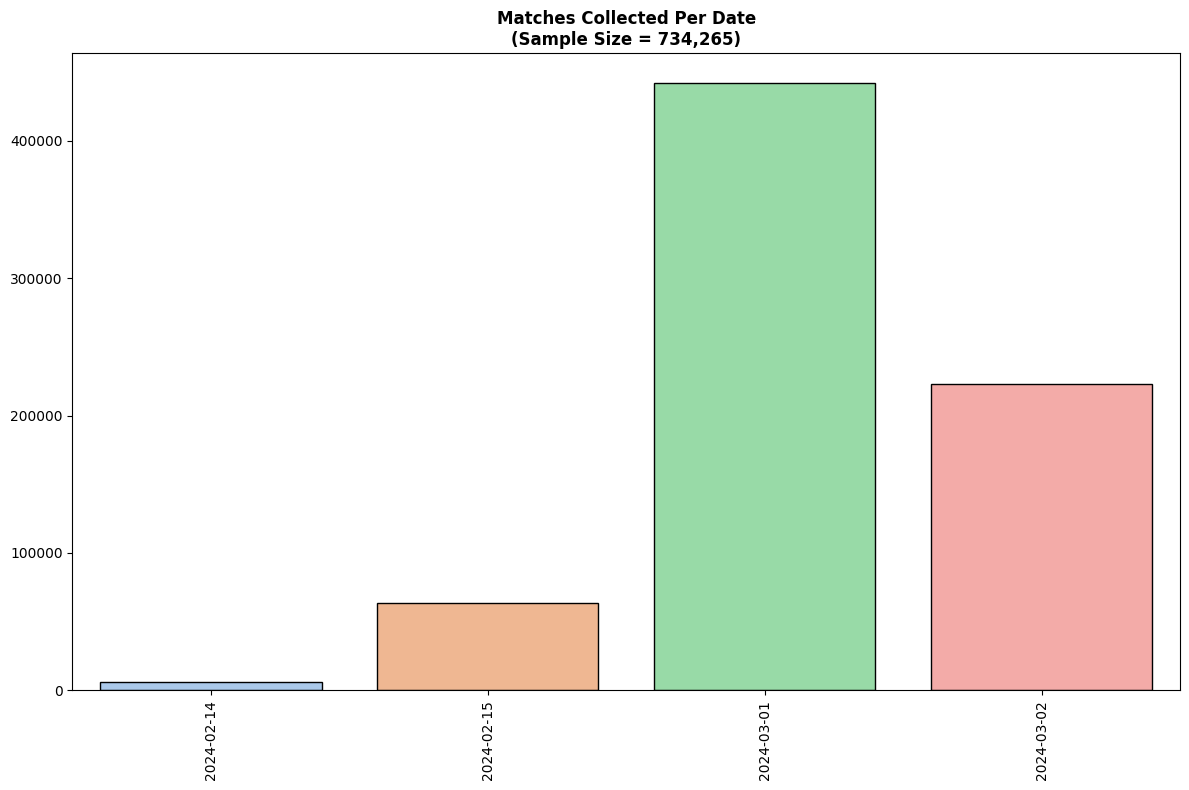

In [135]:
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(100)

match_dates = pd.to_datetime(df_raw["battleAt"], unit="s").dt.to_period("D")
match_date_counts = match_dates.groupby(lambda x: match_dates[x]).count().reset_index()

colors = sns.color_palette("pastel", n_colors=len(match_date_counts))
title = f"Matches Collected Per Date\n(Sample Size = {len(df_raw):,})"
plot_bar(match_date_counts, x="index", y="battleAt", xlabels=match_date_counts["index"], colors=colors, title=title, annot=False)

In [136]:
matchup_fns = Path(os.path.join(data_dir, "matchup_data")).rglob("*.csv")
matchup_dfs = [pd.read_csv(f) for f in matchup_fns
          if (int(re.findall(r'\d+', str(f))[-1]) >= rank_low)
          and (int(re.findall(r'\d+', str(f))[-1]) <= rank_high)]
df_matchups = pd.concat(matchup_dfs).groupby(["char", "other_char"]).agg(
    {"n_games": "sum", "n_wins": "sum", "win_rate": "mean"}).reset_index()
df_matchups.head()

,char,other_char,n_games,n_wins,win_rate
0,chr_0000,chr_0000,0.0,0.0,NaN
1,chr_0000,chr_0001,387.0,188.0,0.542789
2,chr_0000,chr_0002,667.0,343.0,0.576190
3,chr_0000,chr_0003,509.0,239.0,0.477300
4,chr_0000,chr_0004,547.0,252.0,0.450000


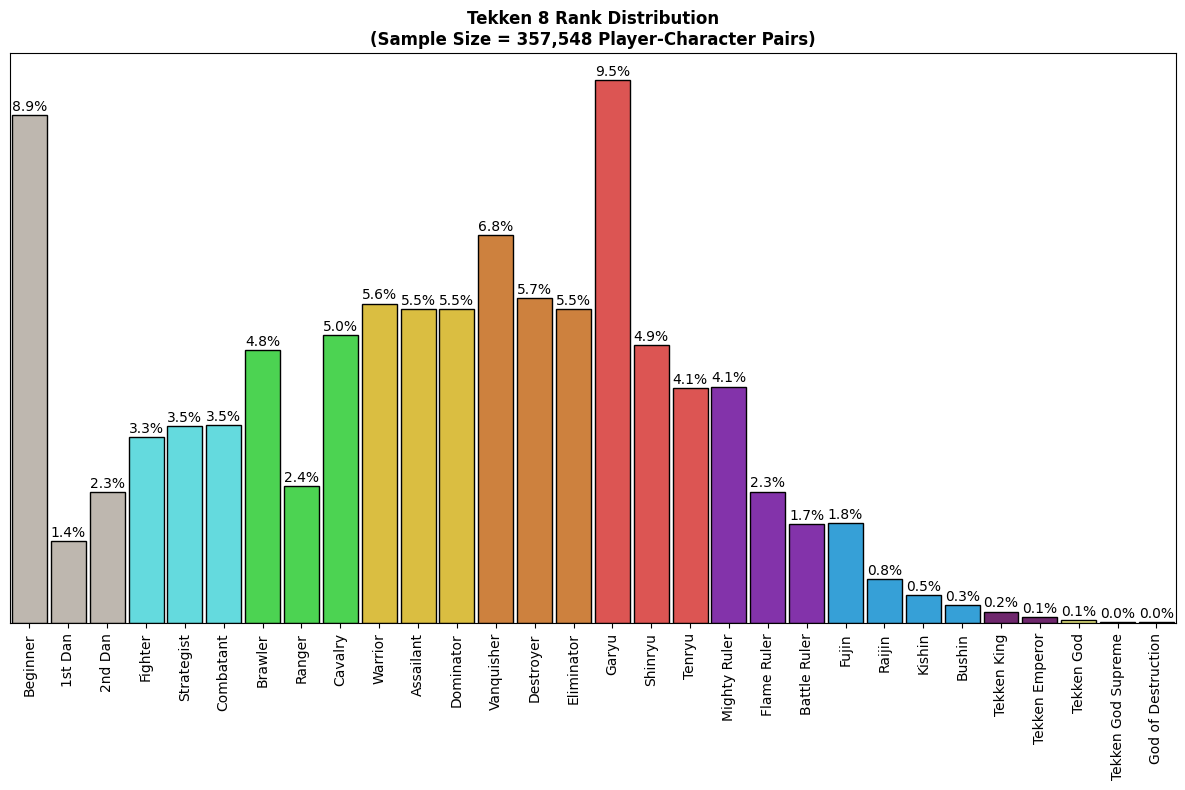

In [137]:
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(100)

title = f"Tekken 8 Rank Distribution\n(Sample Size = {len(df_player):,} Player-Character Pairs)"
x = "rank_id"
xlabels = list(dan_names_dict.values())[:-1]
colors = list(rank_color_dict.values())
plot_categorical_histogram(df_player, x, xlabels, colors, title,
                           width=1, gap=0.1, legend=False, edgecolor="black")

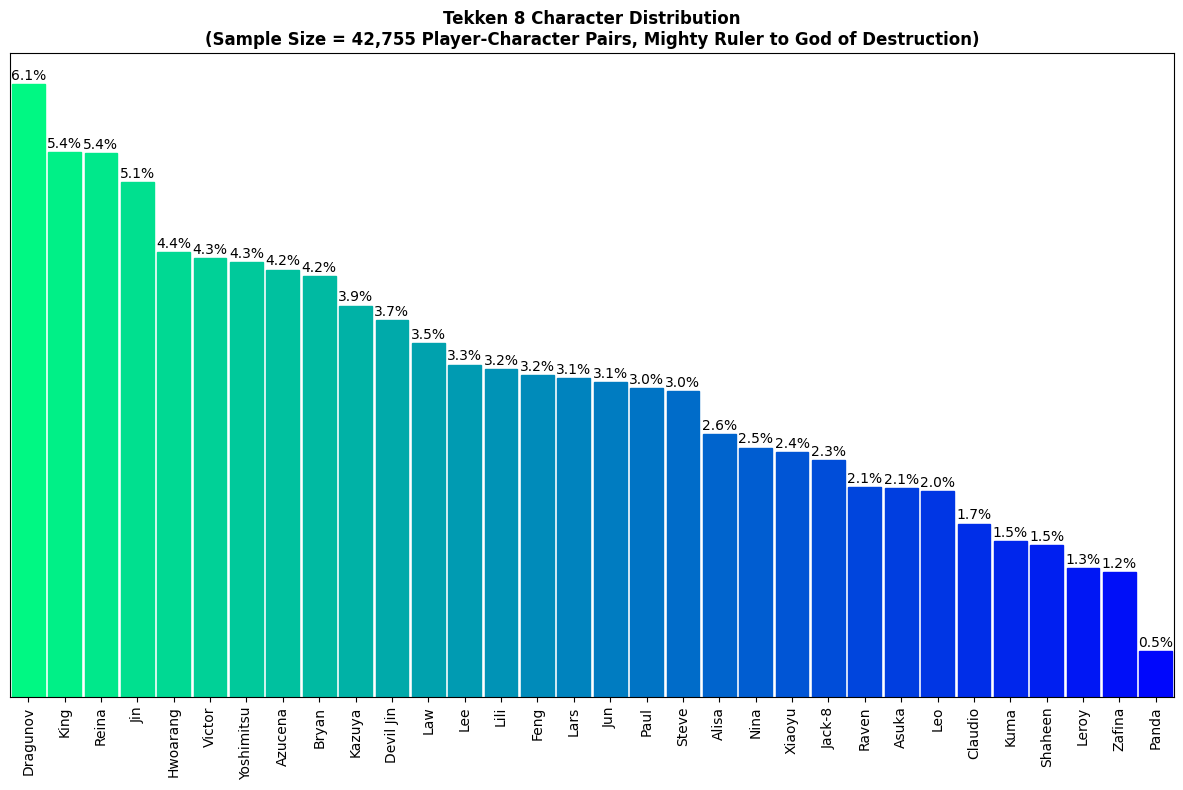

In [138]:
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(100)

char_ids_by_occurance = df_player_subset.groupby("character_id").count().iloc[:, 0].sort_values(ascending=False).index

title = f"Tekken 8 Character Distribution\n(Sample Size = {len(df_player_subset):,} Player-Character Pairs, {rank_text})"
x = "character_id"
xlabels = [char_dict[k] for k in char_ids_by_occurance]
colors = sns.color_palette("winter", n_colors=len(char_ids_by_occurance))
plot_categorical_histogram(df_player_subset, x, xlabels, colors, title, order=char_ids_by_occurance,
                           width=1, gap=0.1, legend=False, edgecolor="black")

/tmp/ipykernel_10836/1645499661.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_wins_1p = df_subset.groupby("1pCharaId").apply(lambda r: (r["winResult"] - 1) == 0).reset_index(level=0).rename(columns={"1pCharaId": "char"})
/tmp/ipykernel_10836/1645499661.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_wins_2p = df_subset.groupby("2pCharaId").apply(lambda r: (r["winResult"] - 1) == 1).reset_ind

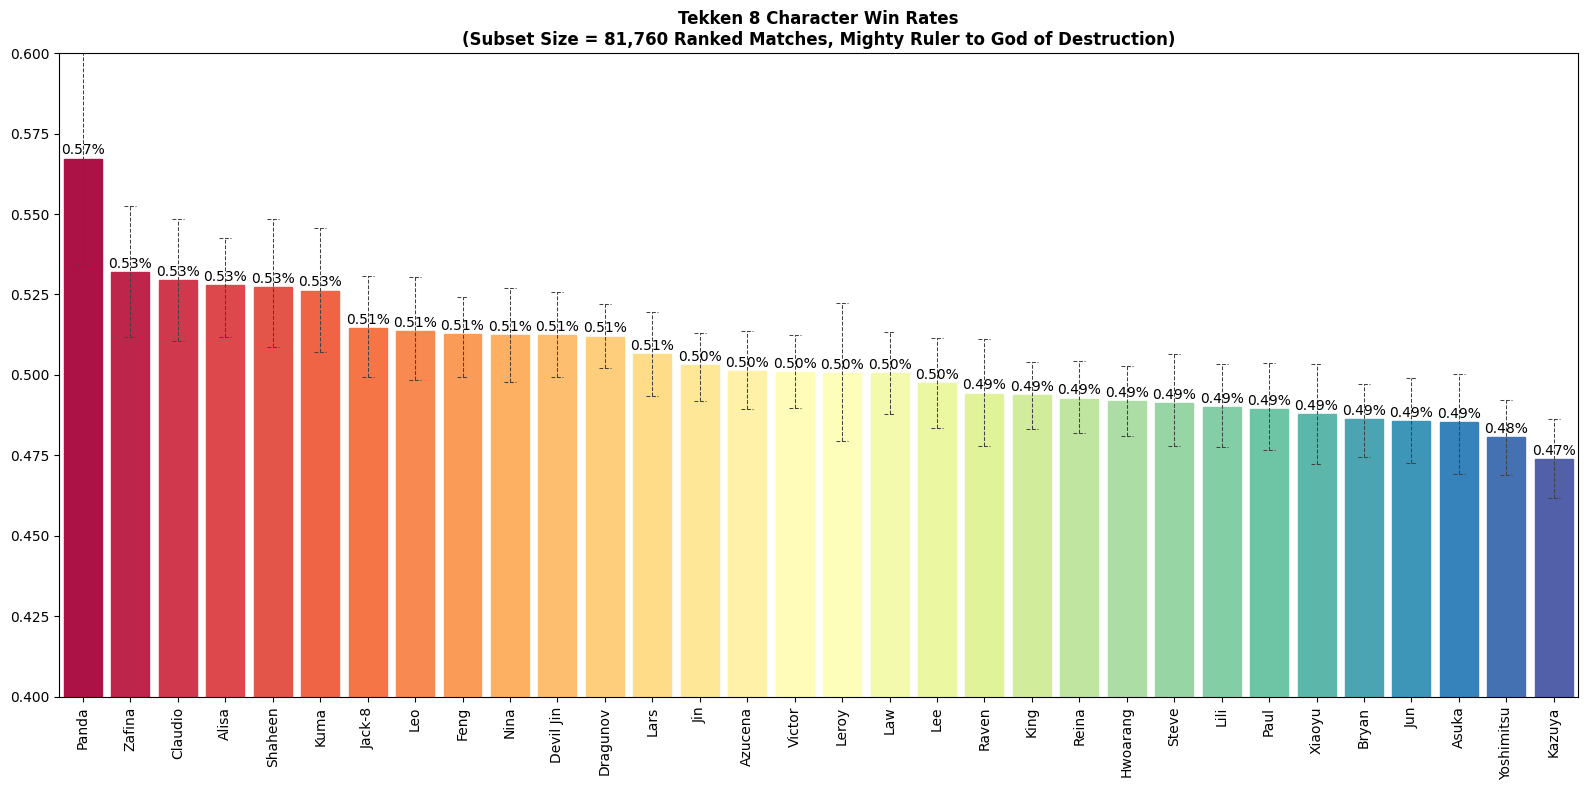

In [139]:
plt.gcf().set_size_inches(16, 8)
plt.gcf().set_dpi(100)

df_wins_1p = df_subset.groupby("1pCharaId").apply(lambda r: (r["winResult"] - 1) == 0).reset_index(level=0).rename(columns={"1pCharaId": "char"})
df_wins_2p = df_subset.groupby("2pCharaId").apply(lambda r: (r["winResult"] - 1) == 1).reset_index(level=0).rename(columns={"2pCharaId": "char"})
df_wins = pd.concat([df_wins_1p, df_wins_2p], ignore_index=True)

order = df_wins.groupby("char").mean().sort_values("winResult", ascending=False).index
title = f"Tekken 8 Character Win Rates\n(Subset Size = {len(df_subset):,} Ranked Matches, {rank_text})"
x = "char"
y = "winResult"
xlabels = [char_dict[c] for c in order]
colors = sns.color_palette("Spectral_r", n_colors=len(xlabels))
plot_bar(df_wins, x, y, xlabels, colors, title, ylim=(0.4, 0.6), order=order, 
         capsize=0.25, err_kws={'linewidth': 0.75, "linestyle": "--"})

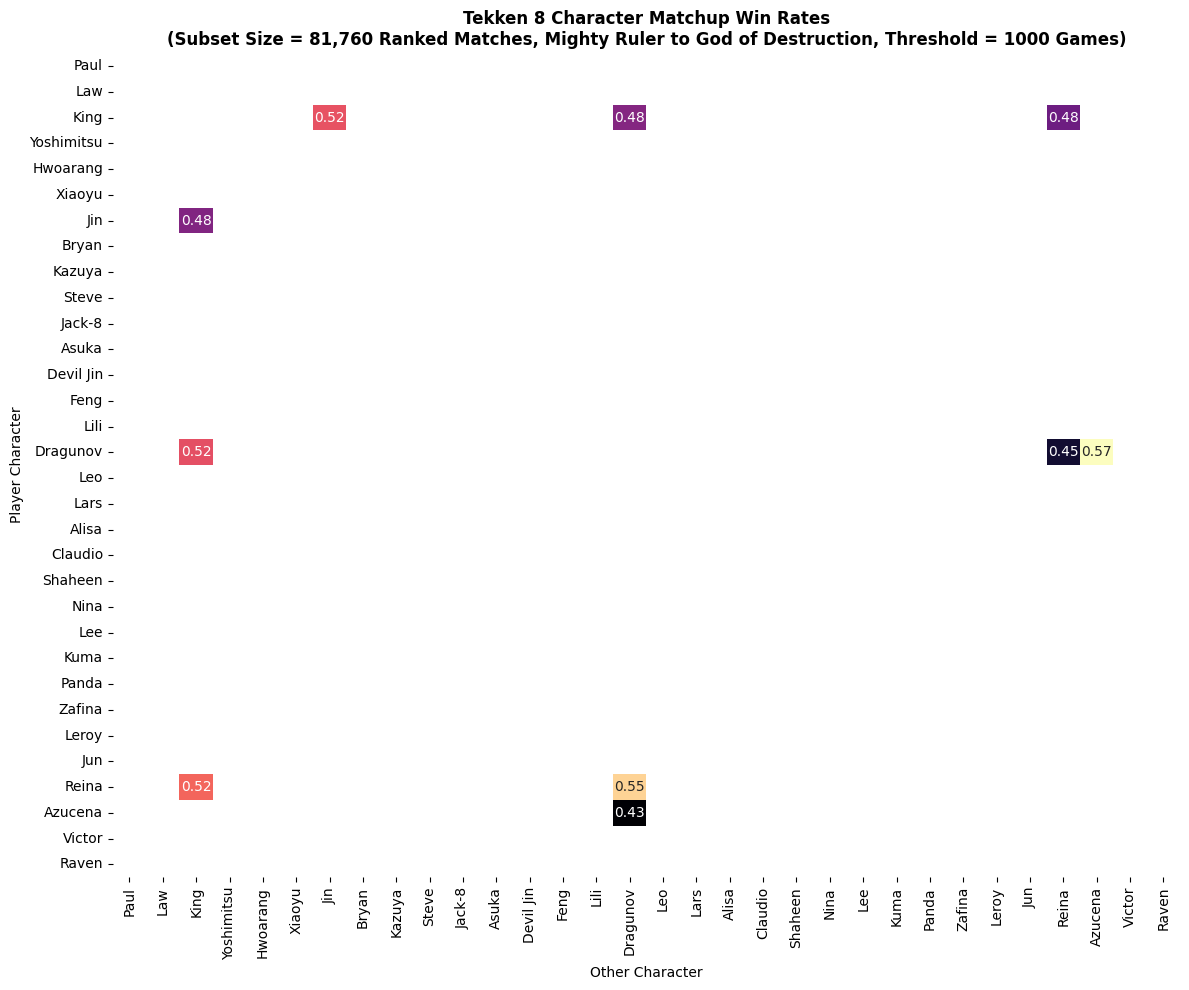

In [140]:
plt.gcf().set_size_inches(12, 10)
plt.gcf().set_dpi(100)

mu_wrs = df_matchups.pivot(index="char", columns="other_char").loc[:, "win_rate"]
mu_games = df_matchups.pivot(index="char", columns="other_char").loc[:, "n_games"]

GAME_THRESHOLD = 1000
mu_wrs[mu_games < GAME_THRESHOLD] = np.NaN

labels = [char_dict[c] for c in mu_wrs.index]
ylabel = "Player Character"
xlabel = "Other Character"
title = f"Tekken 8 Character Matchup Win Rates\n(Subset Size = {len(df_subset):,} Ranked Matches, {rank_text}, Threshold = {GAME_THRESHOLD} Games)"
plot_heatmap(mu_wrs, xlabel, ylabel, labels, labels, title)